<center>

# **Analyse de la Danse de l'Égyptien**
</center>

### I. INSTALLATION ET UTILISATION DE LA LIBRAIRIE

Afin de garantir la fiabilité de nos futures analyses de trajectoires, nous mettons en place un test avec l'outil MMPoseInferencer. L'objectif est de vérifier la fiabilité de la lecture et la visualisation des données.

Nous ciblons ici l'extraction des articulations standards (épaules, coudes, poignets) qui seront les variables importante pour la suite de notre projet.

In [1]:
import mmengine
import mmcv
import mmdet
import mmpose
from mmpose.apis import MMPoseInferencer
import matplotlib.pyplot as plt
import os
import json
import numpy as np
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
01/18 15:19:07 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
01/18 15:19:08 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a corre

/home/user/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


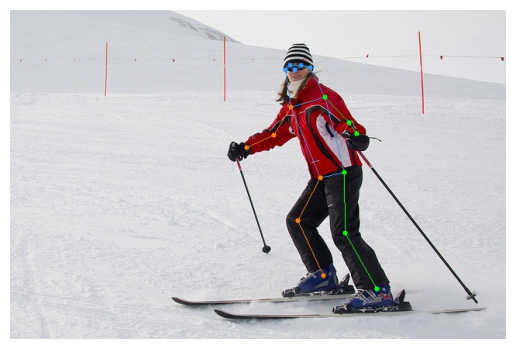

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inferencer = MMPoseInferencer('human', device='cpu') 

image = 'demo.jpg'
result_generator = inferencer(image, vis=True, out_dir='vis_results')
result = next(result_generator)

vis_img_path = os.path.join('vis_results', 'visualizations', os.path.basename(image))
vis_img = mmcv.imread(vis_img_path)

plt.imshow(mmcv.bgr2rgb(vis_img))
plt.axis('off')
plt.show()

On remarque bien ici les articulations du corps avec les yeux, les oreilles et le nez. Nous pouvons donc passer à la suite du projet.

### II. PRÉSENTATION DES DONNÉES UTILISÉES

Nous avons choisi de travailler sur une vidéo du jeu Just Dance. Nous avons donc deux vidéos à analyser :
- La vidéo originale de la danse 
- Une vidéo de nous qui reproduisons cette même danse

Notre but est de comparer nos mouvements par rapport à la vidéo originale pour savoir qui de nous reproduit le mieux la danse.
Nous avons choisi un mouvement assez répétitif afin de pouvoir en tirer une prédiction sur les prochains mouvements.

Nous n'avons pas encore filmé la vidéo de nous qui dansons. Pour l'instant nous allons baser nos analyses sur la vidéo originale et nous rajouterons la semaine prochaine notre vidéo.

In [3]:
# Nous avons pris un extrait raw de just dance afin d'éviter le bruit sur la vidéo

HTML("""
<video width="600" controls>
  <source src="original.mp4" type="video/mp4">
</video>
""")

### PREMIERS RÉSULTATS

Utilisons MMPoseInferencer afin d'extraire les keypoints de nos vidéos.

In [4]:
original = 'original.mp4'

result_generator = inferencer(original, vis=True, out_dir='vis_results')

for frame_result in result_generator:
    pass

01/18 15:29:48 - mmengine - INFO - the output video has been saved at vis_results/visualizations/original.mp4


L'outil nous génère deux fichiers : 
- Un fichier vidéo mp4 qui reprend la vidéo de base en ajoutant les keypoints directement sur l'image
- Un fichier json qui contient toutes les coordonnées de chaque keypoints image par image et personne par personne

C'est sur ce dernier fichier json que nous allons pouvoir étudier les trajectoires et mouvements de nos personnages.

In [5]:
HTML(""" 
<video width="600" controls>
  <source src="vis_results/visualizations/original.mp4" type="video/mp4">
</video>
""")

### III. ANALYSE DES TRAJECTOIRES

Nous allons utiliser le fichier json pour extraire la positions des poignets du danseur frame par frame. Cependant, les coordonnées brutes extraites par MMPose sont exprimées en pixels. Nous ne pouvons donc pas travailler directement avec ces valeurs car :
- Un danseur proche de l'objectif aura des mouvements qui paraissent "plus grands" qu'un danseur au second plan.
- La taille des membres varie d'un individu à l'autre.

Pour l'instant cela ne pose pas de problème car nous avons qu'une seule vidéo à analyser mais quand nous ajouterons l'analyse de notre danse, nous aurons besoin de données normalisées.

Nous déplaçons donc l'origine du repère au milieu de la ligne des épaules. Ainsi, la position du poignet est mesurée relativement au buste et non au cadre de l'image.

La formule appliquée pour chaque frame est :

$$Y_{norm} = \frac{Y_{poignet} - Y_{milieu\_épaules}}{Distance(Épaule_{G}, Épaule_{D})}$$

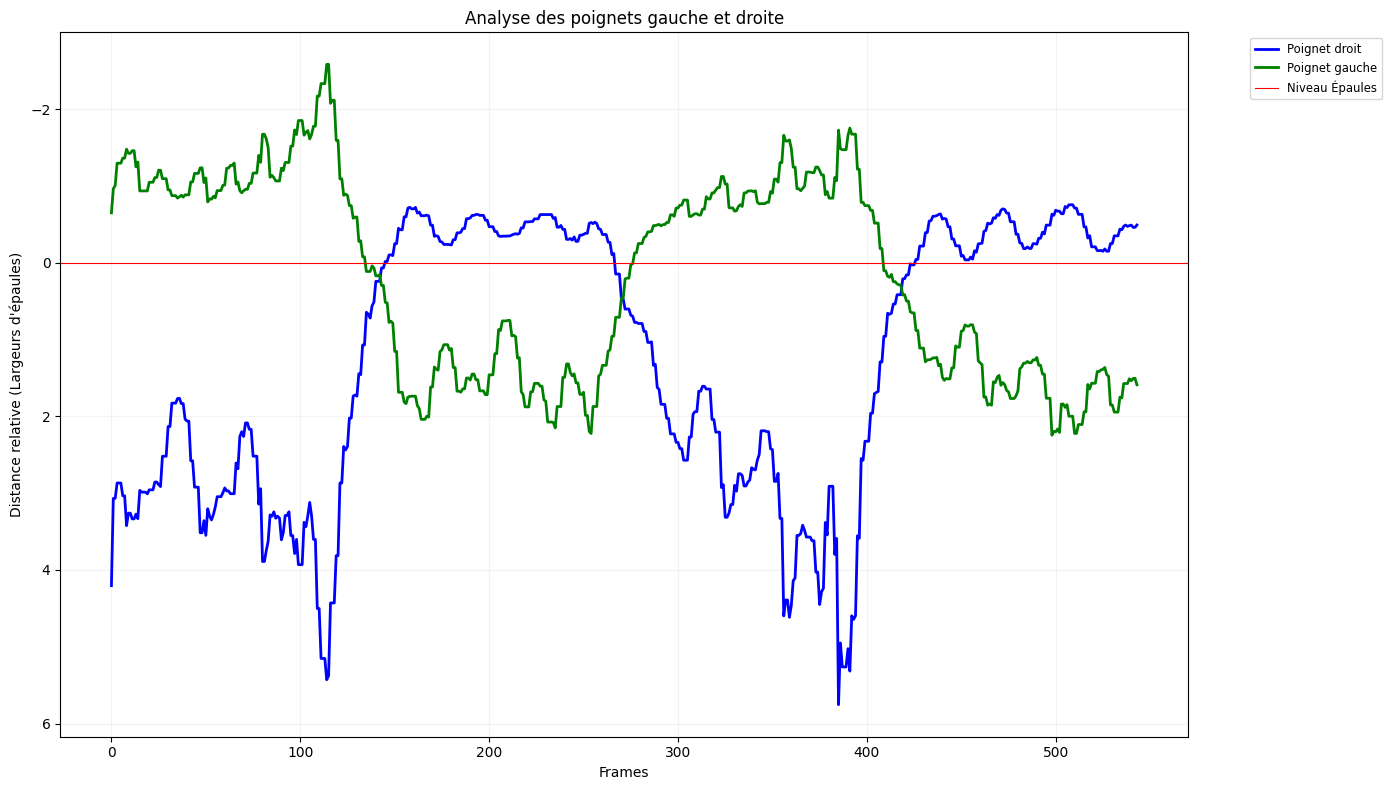

In [6]:
def trajectoires_normalisees(nom_fichier, nb_danseurs=1):
    with open(nom_fichier, 'r') as f:
        data = json.load(f)
    
    frames = []
    # On prépare des listes pour stocker les poignets droits et gauches
    traj_droit = [[] for _ in range(nb_danseurs)]
    traj_gauche = [[] for _ in range(nb_danseurs)]
    
    for f_data in data:
        frames.append(f_data['frame_id'])
        # Tri des personnes de gauche à droite pour ne pas mélanger les courbes
        insts = sorted(f_data['instances'], key=lambda x: np.mean([kp[0] for kp in x['keypoints']]))
        
        for i in range(nb_danseurs): #on tente d'éliminer les "fantômes" en saisissant manuellement le nombre supposé de danseurs dans nb_danseurs
            if i < len(insts):
                keypoints = np.array(insts[i]['keypoints'])
                
                # 1. Calcul du milieu des épaules (référence 0)
                milieu_epaules = (keypoints[5][1] + keypoints[6][1]) / 2 #standard COCO human keypoints : 5=épaules gauche, 6=épaule droite
                
                # 2. Calcul de la largeur des épaules (unité de normalisation)
                largeur_epaules = np.linalg.norm(np.array(keypoints[5][:2]) - np.array(keypoints[6][:2]))
                largeur_epaules = largeur_epaules if largeur_epaules > 0 else 1
                
                # 3. Calcul de la position relative (Y_poignet - Y_épaules) / Largeur_Épaules
                traj_droit[i].append((keypoints[10][1] - milieu_epaules) / largeur_epaules) #10=poignet droit
                traj_gauche[i].append((keypoints[9][1] - milieu_epaules) / largeur_epaules) #9=poignet gauche
            else:
                traj_droit[i].append(None)
                traj_gauche[i].append(None)
                
    return frames, traj_droit, traj_gauche


frames, poignet_droit, poignet_gauche = trajectoires_normalisees('vis_results/predictions/original.json', nb_danseurs=1)

plt.figure(figsize=(14, 8))
plt.plot(frames, poignet_droit[0], color='blue', linewidth=2, label='Poignet droit')
plt.plot(frames, poignet_gauche[0], color='green', linewidth=2, label='Poignet gauche')
plt.axhline(0, color='red', linestyle='-', linewidth=0.8, label='Niveau Épaules')
plt.title("Analyse des poignets gauche et droite")
plt.xlabel("Frames")
plt.ylabel("Distance relative (Largeurs d'épaules)")
plt.gca().invert_yaxis() 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, alpha=0.15)
plt.tight_layout()

plt.show()

On remarque bien ici le mouvement des poignets par rapport aux épaules, c'est un mouvement répétitif et symétrique par rapport aux épaules ce qui va faciliter la prédiction. La ligne d'épaule ne bouge pas puisque c'est l'origine du repère.On observe ici uniquement le mouvement des poignets par rapport aux épaules et non par rapport à la caméra.

 ### IV. PRÉDICTION DES PROCHAINS MOUVEMENTS

Notre stratégie de modélisation se décomposera en deux temps :

- Approche supervisée : implémentation d'un réseau récurrent type LSTM pour modéliser la dynamique temporelle de la danse. Ce modèle servira de référence pour la prédiction de trajectoires courtes.

- Apprentissage par renforcement : utilisation de l'algorithme PPO (Proximal Policy Optimization) pour entraîner un agent virtuel à faire la danse de l'égyptien. L'environnement sera défini par la distance entre l'agent et la trajectoire normalisée du fichier original.json. Cette approche permettra de tester la robustesse du mouvement face à des perturbations.

#### IV.1) APPROCHE SUPERVISÉE

Le but ici est de prédire la frame t+1 en fonction des frames précédentes. Nous allons utiliser la MSE comme loss.

Tout d'abbord, nous devons normaliser tous les points par rapport aux centre des épaules, jusqu'ici, nous avions étudié seulement les poignets mais pour la prédiction nous avons besoin de tous les keypoints.

In [7]:
def prepare_stable_data(file_name, window_size=45):
    with open(file_name, 'r') as f:
        data = json.load(f)
    
    all_frames_data = []
    for f_data in data:
        if len(f_data['instances']) > 0:
            kp = np.array(f_data['instances'][0]['keypoints']) 
            # On centre sur les épaules
            center = (kp[5] + kp[6]) / 2
            # On normalise la taille
            scale = np.linalg.norm(kp[5] - kp[6])
            if scale == 0: scale = 1.0
            norm_kp = (kp - center) / scale
            all_frames_data.append(norm_kp.flatten())
    
    all_frames_data = np.array(all_frames_data)
    
    X, y = [], []
    for i in range(len(all_frames_data) - window_size):
        X.append(all_frames_data[i : i + window_size]) #toutes les frames sauf la dernière
        y.append(all_frames_data[i + window_size]) # seulement la dernière frame
        
    return np.array(X), np.array(y), all_frames_data

# APPEL DE LA FONCTION (Vérifie bien ton chemin de fichier !)
# J'utilise window_size=30 pour un bon compromis mémoire/stabilité
X_train, y_train, full_pos = prepare_stable_data('vis_results/predictions/original.json', window_size=20)

X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(f"OK ! Données prêtes. X: {X_train.shape}, y: {y_train.shape}")

OK ! Données prêtes. X: (524, 20, 34), y: (524, 34)


In [8]:
model = PosePredictor(input_dim=34, hidden_dim=256, num_layers=3).to(device) # Modèle un peu plus costaud
optimizer = optim.Adam(model.parameters(), lr=0.0005) # Apprentissage plus lent/précis
criterion = nn.MSELoss()

epochs = 300 # On lui en donne plus pour l'égyptien
for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

NameError: name 'PosePredictor' is not defined

In [ ]:
model.eval()
input_seq = X_tensor[-1:].to(device) 
current_pos = full_pos[-1] # La dernière pose réelle

generated_frames = []
# --- PARAMÈTRE DE TRICHE ---
alpha = 1.5 # Plus ce chiffre est grand, plus l'IA va forcer ses mouvements (essaie 1.5 ou 2.0)

with torch.no_grad():
    for _ in range(60):
        # 1. L'IA prédit la pose "prudente"
        pred_pose = model(input_seq).cpu().numpy().squeeze()
        
        # 2. ON BOOST LE MOUVEMENT : On amplifie la différence
        # On calcule le mouvement prévu par rapport à la frame précédente
        movement = pred_pose - input_seq[0, -1, :].cpu().numpy()
        
        # On rajoute ce mouvement multiplié par alpha à la dernière frame
        boosted_pose = input_seq[0, -1, :].cpu().numpy() + (movement * alpha)
        
        # 3. Sécurité pour ne pas que les bras s'allongent trop
        boosted_pose = np.clip(boosted_pose, -3, 6)
        
        generated_frames.append(boosted_pose)
        
        # Mise à jour
        new_frame = torch.from_numpy(boosted_pose).float().to(device).view(1, 1, 34)
        input_seq = torch.cat((input_seq[:, 1:, :], new_frame), dim=1)

generated_frames = np.array(generated_frames)

In [ ]:
def final_dance_show(full_pos, generated_frames):
    # On prend les 30 dernières frames du vrai danseur
    real_part = full_pos[-30:]
    # On colle l'IA
    all_dance = np.concatenate([real_part, generated_frames])
    
    fig, ax = plt.subplots(figsize=(7, 7), facecolor='black')
    
    def update(i):
        ax.clear()
        ax.set_facecolor('black')
        ax.set_xlim(-5, 5)
        ax.set_ylim(10, -5) # On descend bas pour voir les pieds !
        ax.axis('off')
        
        kp = all_dance[i].reshape(17, 2)
        color = '#00FF00' if i < 30 else '#00FFFF' # Vert (Vrai) -> Cyan (IA)
        
        # Liens du squelette
        links = [(5,6),(5,7),(7,9),(6,8),(8,10),(5,11),(6,12),(11,12),(11,13),(13,15),(12,14),(14,16)]
        for s, e in links:
            ax.plot([kp[s,0], kp[e,0]], [kp[s,1], kp[e,1]], color=color, lw=3)
        ax.scatter(kp[:,0], kp[:,1], c='white', s=20)
        ax.set_title("RÉEL (VERT) puis IA GÉNÉRÉE (CYAN)", color='white')

    ani = animation.FuncAnimation(fig, update, frames=len(all_dance), interval=60)
    plt.close()
    return ani

HTML(final_dance_show(full_pos, generated_frames).to_jshtml())